# <center> Практика. 

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Страховая компания хочет ответить на следующие вопросы, касающиеся страховых выплат:

В процессе своего анализа вы должны:

- Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?



Данные содержат следующие столбцы:
*   work_year - Год, в котором была выплачена зарплата.
* experience_level - Опыт работы на этой должности в течение года со следующими возможными значениями:
* EN — Entry-level/Junior;
* MI — Mid-level/Intermediate;
* SE — Senior-level/Expert;
* EX — Executive-level/Director.
* employment_type - Тип трудоустройства для этой роли:
* PT — неполный рабочий день;
* FT — полный рабочий день;
* CT — контракт;
* FL — фриланс.
* job_title - Роль, в которой соискатель работал в течение года.
* salary - Общая выплаченная валовая сумма заработной платы.
* salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* remote_ratio -Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
* company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).


## Загрузка данных

In [64]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.contingency_tables import mcnemar

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# прочитаем датасет 
data = pd.read_csv('ds_salaries.csv', index_col=[0])

In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [ ]:
data.info()

В датасете 607 записей (без пропущенных значений). В датасете 5 столбцов с числовыми и 7 с категориальными признаками 

Проверка данных на наличие полных дубликатов:

In [4]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


Проверка на возможные выбросы в колонке Salary

In [5]:
data_agg = data['salary'].describe().round(2).to_frame()
data_agg.columns = ['Размер з.п.']
data_agg

,Размер з.п.
count,565.00
mean,338115.99
std,1599878.79
min,4000.00
25%,67000.00
50%,110925.00
75%,165000.00
max,30400000.00


Видно, что з.п. имеет максимальное значение более 3 миллионов. При анализе исходных данных видно, что стобец salary указывает на уровень з.п. в местной валюте. Считаю, что столбцы salary и salary_currency для данного анализа нам не нужны.

In [6]:
#удаляем стобцы salary и salary_currency
data = data.drop(['salary','salary_currency'], axis= 1)

Построим график, чтобы увидеть выбросы.

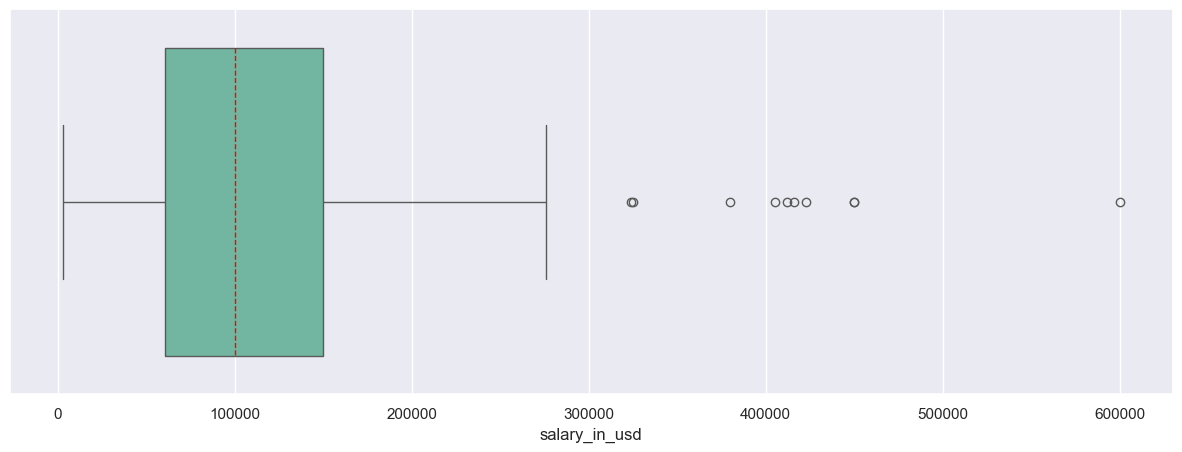

In [7]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(data = data, x = 'salary_in_usd', orient='h', medianprops={"color": "red", "linestyle": '--'})

plt.show()

Как видно, основная з.п. находится в пределах 300 000 USD, остальное, я бы считал не несущим пользы и удалил эти признаки

In [8]:
#убираем результаты с з.п. более 300.000
outliers = data[data['salary_in_usd']>300000]
cleaned_data = data.drop(outliers.index, axis =0)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           555 non-null    int64 
 1   experience_level    555 non-null    object
 2   employment_type     555 non-null    object
 3   job_title           555 non-null    object
 4   salary_in_usd       555 non-null    int64 
 5   employee_residence  555 non-null    object
 6   remote_ratio        555 non-null    int64 
 7   company_location    555 non-null    object
 8   company_size        555 non-null    object
dtypes: int64(3), object(6)
memory usage: 43.4+ KB


In [9]:
data_agg = cleaned_data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер з.п.']
data_agg

,Размер з.п.
count,555.00
mean,105062.78
std,58981.19
min,2859.00
25%,60000.00
50%,100000.00
75%,145500.00
max,276000.00


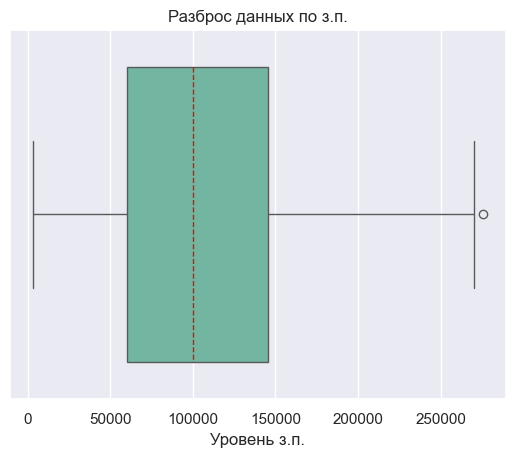

In [11]:
ax = sns.boxplot(cleaned_data, x='salary_in_usd', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Уровень з.п.')
plt.title('Разброс данных по з.п.')
plt.show()

### Рост З.П. (DS) по годам

In [27]:
#Создадим DF для двух специальностей
data1 = cleaned_data[cleaned_data['job_title']=='Data Scientist']
data2 = cleaned_data[cleaned_data['job_title']=='Data Engineer']


In [19]:
data_agg = data1.groupby('work_year')['salary_in_usd'].describe().round(2)
print('З.п. в зависимости от года работы')
data_agg

З.п. в зависимости от года работы


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,20.0,69669.05,33268.11,21669.0,41768.00,62726.0,94677.75,138350.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


Как видно, рост зарплаты с каждым годом присутствует, особенно это видно в 2022 году. При этом средняя в 2020 и 2021 году примерно одинаковая. Также в 2021 году есть похожее на "выброс" значение min. С ним, если расмматривать отдельно 2021 год, можно поработать. Посморим на графике. 

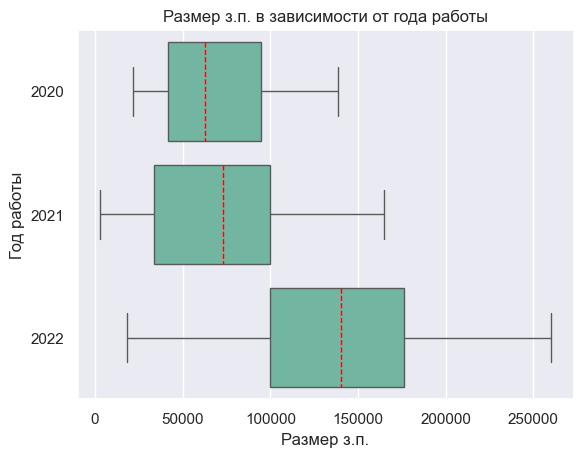

In [105]:
ax = sns.boxplot(data1, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер з.п.', ylabel='Год работы')
plt.title('Размер з.п. в зависимости от года работы')
plt.show()

### З.П.(Data Science) в зависимости от размера компании

In [103]:
data_agg = data1.groupby('company_size')['salary_in_usd'].describe().round(2)
print('З.п. в зависимости от размера компании')
data_agg

З.п. в зависимости от размера компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,44.0,96297.75,54872.66,13400.0,47620.25,90734.0,135000.0,215300.0
M,77.0,126380.75,56389.53,4000.0,90000.00,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.00,49268.0,82500.0,105000.0


Как видно, что средний уровень з.п. у средней компании, больше чем у крупной, но их и больше по количеству. Посмотрим график.

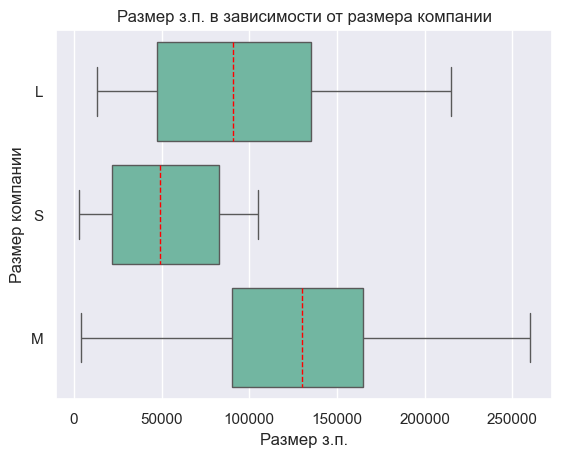

In [86]:
ax = sns.boxplot(data1, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер з.п.', ylabel='Размер компании')
plt.title('Размер з.п. в зависимости от размера компании')
plt.show()

### З.п.(DS) в зависимости от опыта работы

In [88]:
data_agg = data1.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('З.п. в зависимости от опыта')
data_agg

З.п. в зависимости от опыта


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,60.0,148653.87,48806.50,20171.0,120000.0,140400.0,180000.00,260000.0


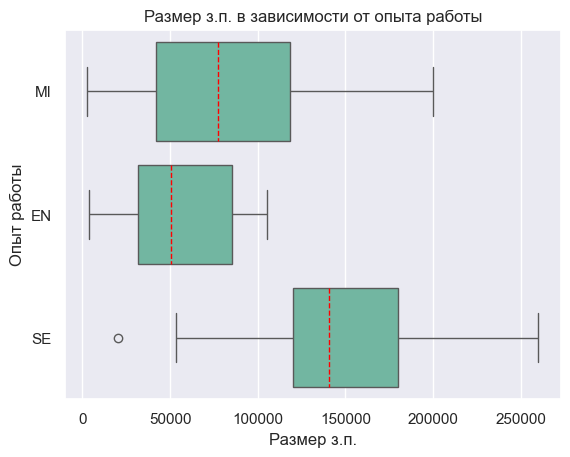

In [98]:
ax = sns.boxplot(data1, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер з.п.', ylabel='Опыт работы')
plt.title('Размер з.п. в зависимости от опыта работы')
plt.show()

### Зависимость з.п. (DS) от типа занятости

In [108]:
data_agg = data1.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('З.п. в зависимости от типа занятости')
data_agg

З.п. в зависимости от типа занятости


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,139.0,106742.38,59189.76,2859.0,54724.00,104702.0,140850.00,260000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


Как видо из данных, для DS, нам актуальны только FT, так как FL и PT, по 1 и 2 сотрудникам соответственно. Но если сравнивать имеющиеся данные, то видна следующая тенденция роста з.п. FT-FL-PT. Посмтрим график. 

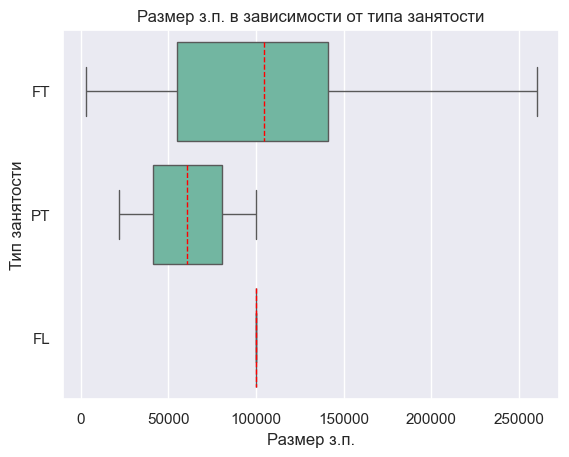

In [109]:
ax = sns.boxplot(data1, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер з.п.', ylabel='Тип занятости')
plt.title('Размер з.п. в зависимости от типа занятости')
plt.show()

### Зависимость з.п.(DS) от объема работы 

In [15]:
data_agg = data1.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('З.п. в зависимости от объема работ удаленно')
data_agg

З.п. в зависимости от объема работ удаленно


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,38.0,98444.97,58647.60,2859.0,49781.25,93582.0,139050.0,215300.0
50,24.0,73827.83,36204.18,20171.0,47783.75,62726.0,102250.0,147000.0
100,67.0,112073.87,61329.08,5679.0,60412.00,105000.0,159100.0,260000.0


Видно, что самый высокий уровень з.п. у тех, у кого уровень удаленной работы, составляет 100, то есть более 80%  работы выполняется удаленно. Затем идет отсутствие удаленной работы. При этом минимальный уровень з.п. самый высокий у уровня 50. Посмотрим график.

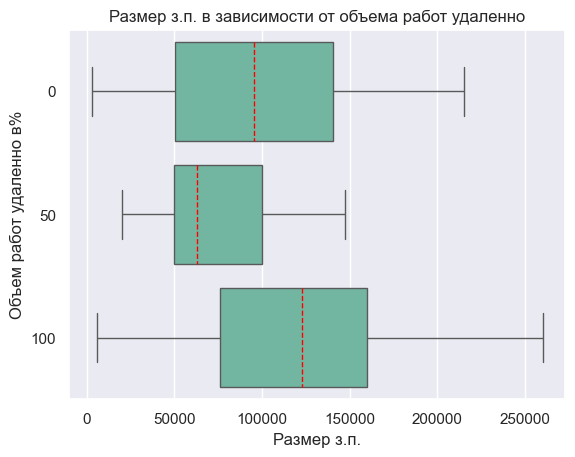

In [113]:
ax = sns.boxplot(data1, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер з.п.', ylabel='Объем работ удаленно в%')
plt.title('Размер з.п. в зависимости от объема работ удаленно')
plt.show()

## Статистический анализ данных



In [11]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### 1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты года ($μ_1$) статистически меньше либо равен размеру зарплаты предыдущего года ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты года ($μ_1$) статистически больше, чем размер зарплаты предыдущего года ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [12]:
# значения з.п. от года
salary_2020 = data1[data1['work_year']==2020]['salary_in_usd']
salary_2021 = data1[data1['work_year']==2021]['salary_in_usd']
salary_2022 = data1[data1['work_year']==2022]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])



Для 2020:
p-value = 0.145
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать ОДнофакторный дисперсионный анализ ANOVA.

**Проведём тест**

In [20]:
# проводим тест
_, p = stats.f_oneway(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод
Зарплаты года увеличиваются по сравнению с предыдущим годом.


### 2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты DE ($μ_1$) статистически меньше либо равны размеру зарплаты DS в 2022 году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты DE в 2022 году ($μ_1$) статистически больше, чем размер зарплаты DS в 2022 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [15]:
# значения з.п. по DS и DE на 2022 
salary_DS_2022 = data1[data1['work_year']==2022]['salary_in_usd']
salary_DE_2022 = data2[data2['work_year']==2022]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для DS:')
result = stats.shapiro(salary_DS_2022)
decision_normality(result[1])

print('Для DE:')
result = stats.shapiro(salary_DE_2022)
decision_normality(result[1])


Для DS:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DE:
p-value = 0.021
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать ОДнофакторный дисперсионный анализ ANOVA.

**Проведём тест**

In [22]:
_, p = stats.ttest_ind(salary_DS_2022, salary_DE_2022, alternative='greater', equal_var=True)
decision_hypothesis(p)

p-value = 0.157
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## Вывод
Заработная плата у DE меньше либо равна з.п. DS

### 3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты DS в меньших компаниях ($μ_1$) статистически меньше размера зарплаты DS в крупных компаниях ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты DS в меньших компаниях ($μ_1$) статистически больше размера зарплаты DS в крупных компаниях ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [28]:
# значения з.п. по DS и DE на 2022 
salary_DS_S = data1[data1['company_size']=='S']['salary_in_usd']
salary_DS_M = data1[data1['company_size']=='M']['salary_in_usd']
salary_DS_L = data1[data1['company_size']=='L']['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_DS_S)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_DS_M)
decision_normality(result[1])

print('Для L:')
result = stats.shapiro(salary_DS_L)
decision_normality(result[1])

Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.030
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Да.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать критерий Фридмана.

**Проведём тест**

### 4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): наличие должностей DS и DE ($μ_1$) не зависит от размера компании ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплаты DS в меньших компаниях ($μ_1$) статистически больше размера зарплаты DS в крупных компаниях ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [ ]:
s = cleaned_data.loc[(cleaned_data['job_title']=='Data Scientist') | (cleaned_data['job_title']=='Data Engineer')]
s

In [68]:
# значения з.п. по DS и DE на 2022 
table = pd.crosstab(s['job_title'], s['company_size'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)
decision_normality(result[1])


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
